# Neural Networks from Scratch: A Pedagogical Implementation

This notebook provides a comprehensive, step-by-step walkthrough of building, training, and understanding neural networks from first principles using NumPy.

**Learning Objectives:**
1. Understand the mathematical foundations of neural networks
2. Implement forward and backward propagation from scratch
3. Train networks on nonlinearly separable problems (XOR)
4. Validate implementations through gradient checking
5. Compare with PyTorch implementations

**Prerequisites:** Basic linear algebra, calculus, and Python programming

In [ ]:
# Environment Setup: Works seamlessly in both Google Colab and local Jupyter
import os
import sys

# Detect execution environment
try:
    import google.colab
    IN_COLAB = True
    print("🌐 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Running locally")

if IN_COLAB:
    # Clone repository if not already present
    if not os.path.exists('/content/neural-network'):
        print("📦 Cloning repository...")
        !git clone https://github.com/shiong-tan/neural-network.git /content/neural-network
        print("✓ Repository cloned")
    else:
        print("✓ Repository already present")
    
    # Add project root to Python path
    project_root = '/content/neural-network'
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
    
    # Change to notebooks directory for relative file paths
    os.chdir('/content/neural-network/notebooks')
    print(f"📁 Working directory: {os.getcwd()}")
    
    # Install dependencies quietly
    print("📚 Installing dependencies...")
    !pip install -q numpy matplotlib torch jupyter pytest
    print("✓ Dependencies installed")
    
    print(f"✅ Python path includes: {project_root}")
    print(f"✅ Colab environment ready!\n")
else:
    # Local execution - add parent directory to path
    sys.path.append('..')
    print("✓ Using local environment\n")

In [ ]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.models import OneHiddenLayerMLP
from src.activations import ReLU, Sigmoid
from src.data import generate_xor_data, generate_spiral_data
from src.optimization import SGD, train, evaluate
from src.gradient_check import check_all_gradients
from src.visualization import plot_training_history, plot_decision_boundary, plot_dataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✓ All imports successful!")

## Part 1: Mathematical Foundations

### 1.1 Network Architecture

We implement a **one-hidden-layer Multi-Layer Perceptron (MLP)**:

$$
\begin{align}
a_1 &= W_1 x + b_1 \in \mathbb{R}^h \quad \text{(first affine)} \\
h_1 &= \varphi(a_1) \in \mathbb{R}^h \quad \text{(activation)} \\
f &= W_2 h_1 + b_2 \in \mathbb{R} \quad \text{(output)}
\end{align}
$$

Where:
- $x \in \mathbb{R}^d$: input
- $W_1 \in \mathbb{R}^{h \times d}$, $b_1 \in \mathbb{R}^h$: first layer parameters
- $\varphi$: activation function (ReLU or sigmoid)
- $W_2 \in \mathbb{R}^{1 \times h}$, $b_2 \in \mathbb{R}$: second layer parameters

### 1.2 Loss Function

We use **squared error loss**:

$$L = \frac{1}{2}(f - y)^2$$

The factor $\frac{1}{2}$ simplifies the gradient: $\frac{\partial L}{\partial f} = f - y$

## Part 2: Activation Functions

Activation functions introduce **non-linearity**, enabling networks to learn complex patterns.

### 2.1 ReLU (Rectified Linear Unit)

$$\text{ReLU}(z) = \max(0, z)$$

$$\text{ReLU}'(z) = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{otherwise} \end{cases}$$

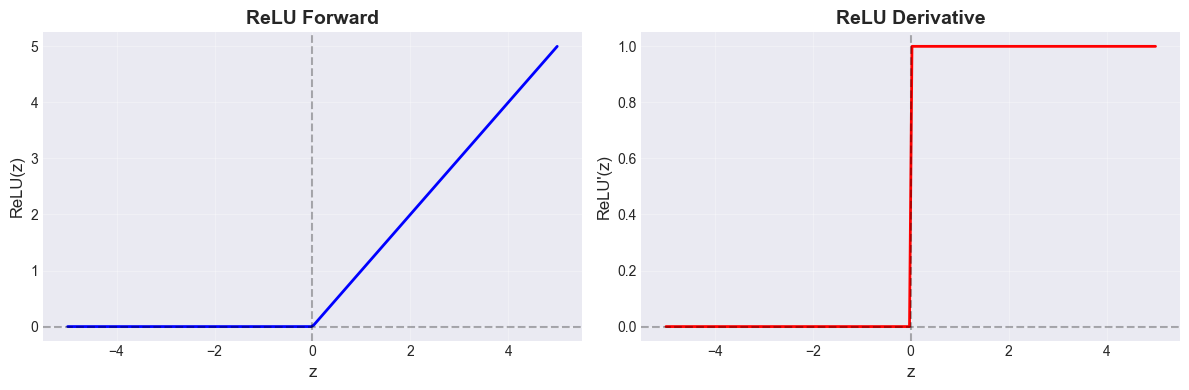

ReLU is piecewise linear: zero for negative inputs, identity for positive.


In [2]:
# Visualize ReLU
z = np.linspace(-5, 5, 200)
relu = ReLU()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Forward
ax1.plot(z, relu.forward(z), 'b-', linewidth=2)
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(0, color='k', linestyle='--', alpha=0.3)
ax1.set_xlabel('z', fontsize=12)
ax1.set_ylabel('ReLU(z)', fontsize=12)
ax1.set_title('ReLU Forward', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Derivative
ax2.plot(z, relu.derivative(z), 'r-', linewidth=2)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('z', fontsize=12)
ax2.set_ylabel("ReLU'(z)", fontsize=12)
ax2.set_title('ReLU Derivative', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ReLU is piecewise linear: zero for negative inputs, identity for positive.")

### 2.2 Sigmoid

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

$$\sigma'(z) = \sigma(z)(1 - \sigma(z))$$

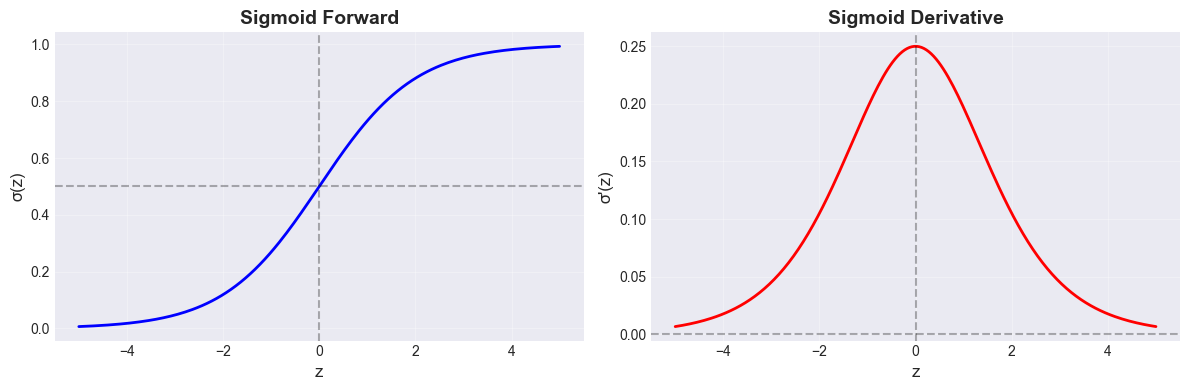

Sigmoid squashes inputs to (0, 1), useful for probabilistic outputs.


In [3]:
# Visualize Sigmoid
sigmoid = Sigmoid()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Forward
ax1.plot(z, sigmoid.forward(z), 'b-', linewidth=2)
ax1.axhline(0.5, color='k', linestyle='--', alpha=0.3)
ax1.axvline(0, color='k', linestyle='--', alpha=0.3)
ax1.set_xlabel('z', fontsize=12)
ax1.set_ylabel('σ(z)', fontsize=12)
ax1.set_title('Sigmoid Forward', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Derivative
ax2.plot(z, sigmoid.derivative(z), 'r-', linewidth=2)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('z', fontsize=12)
ax2.set_ylabel("σ'(z)", fontsize=12)
ax2.set_title('Sigmoid Derivative', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Sigmoid squashes inputs to (0, 1), useful for probabilistic outputs.")

## Part 3: Forward Propagation

### 3.1 Create and Initialize Model

In [4]:
# Create a simple model
model = OneHiddenLayerMLP(input_dim=2, hidden_dim=4, activation='relu')
print(model)

# Inspect parameters
params = model.get_parameters()
print(f"\nParameter shapes:")
for name, param in params.items():
    print(f"  {name}: {param.shape}")

OneHiddenLayerMLP(input_dim=2, hidden_dim=4, activation='relu')

Parameter shapes:
  W1: (4, 2)
  b1: (4,)
  W2: (1, 4)
  b2: (1,)


### 3.2 Forward Pass on Sample Input

In [5]:
# Single sample forward pass
x = np.array([1.0, -0.5])
f = model.forward(x)

print(f"Input x: {x}")
print(f"\nIntermediate values:")
print(f"  a₁ (pre-activation): {model.a1_cache}")
print(f"  h₁ (post-activation): {model.h1_cache}")
print(f"\nOutput f: {f:.6f}")

Input x: [ 1.  -0.5]

Intermediate values:
  a₁ (pre-activation): [ 0.05658463 -0.01138264 -0.01170849  0.11954955]
  h₁ (post-activation): [0.05658463 0.         0.         0.11954955]

Output f: -0.008224


## Part 4: Backpropagation

Backpropagation computes gradients using the **chain rule**:

$$\frac{\partial L}{\partial \theta} = \frac{\partial L}{\partial f} \cdot \frac{\partial f}{\partial \theta}$$

### 4.1 Gradient Computation

In [6]:
# Backward pass
y = 1.0  # Target
grads = model.backward(x, y, f)

print(f"Target y: {y}")
print(f"Prediction f: {f:.6f}")
print(f"Loss: {0.5 * (f - y)**2:.6f}")

print(f"\nGradients:")
for name, grad in grads.items():
    print(f"  {name}: shape {grad.shape}, mean {np.mean(np.abs(grad)):.6f}")

Target y: 1.0
Prediction f: -0.008224
Loss: 0.508258

Gradients:
  dL_dW2: shape (1, 4), mean 0.044396
  dL_db2: shape (1,), mean 1.008224
  dL_dW1: shape (4, 2), mean 0.017679
  dL_db1: shape (4,), mean 0.023572


### 4.2 Gradient Checking

Verify analytical gradients match numerical gradients computed via finite differences:

$$\frac{\partial L}{\partial \theta_i} \approx \frac{L(\theta + \epsilon e_i) - L(\theta - \epsilon e_i)}{2\epsilon}$$

In [7]:
# Check all gradients
results = check_all_gradients(model, x, y, epsilon=1e-5, threshold=1e-7)

print("Gradient Checking Results:\n")
for param_name, result in results.items():
    status = "✓ PASS" if result['passed'] else "✗ FAIL"
    print(f"{param_name}: {status} (error: {result['error']:.2e})")

if all(r['passed'] for r in results.values()):
    print("\n✓ All gradients verified correct!")
else:
    print("\n✗ Some gradients failed verification.")

Gradient Checking Results:

W1: ✓ PASS (error: 7.38e-11)
b1: ✓ PASS (error: 2.44e-11)
W2: ✓ PASS (error: 1.12e-11)
b2: ✓ PASS (error: 1.17e-12)

✓ All gradients verified correct!


## Part 5: The XOR Problem

XOR is a classic **nonlinearly separable** problem that cannot be solved by linear models.

### 5.1 Generate XOR Data

In [ ]:
# Generate XOR dataset
X_train, y_train = generate_xor_data(n_samples=200, noise=0.1)
X_val, y_val = generate_xor_data(n_samples=100, noise=0.1)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Visualize XOR data
plot_dataset(X_train, y_train, title='XOR Problem: Nonlinearly Separable')

print("\nLabel distribution:")
print(f"  Class 0: {np.sum(y_train == 0)} samples")
print(f"  Class 1: {np.sum(y_train == 1)} samples")

### 5.2 Train Model on XOR

In [9]:
# Create and train model
xor_model = OneHiddenLayerMLP(input_dim=2, hidden_dim=8, activation='relu')
optimizer = SGD(learning_rate=0.5)

print("Training on XOR...\n")
history = train(
    xor_model, X_train, y_train, optimizer,
    n_epochs=200,
    batch_size=32,
    X_val=X_val,
    y_val=y_val,
    verbose=True,
    print_every=50
)

print("\n✓ Training complete!")

Training on XOR...

Epoch 50/200 - Train Loss: 0.048560, Val Loss: 0.043037
Epoch 100/200 - Train Loss: 0.055981, Val Loss: 0.042483
Epoch 150/200 - Train Loss: 0.048289, Val Loss: 0.048465
Epoch 200/200 - Train Loss: 0.047974, Val Loss: 0.038580

✓ Training complete!


### 5.3 Visualize Training Progress

In [ ]:
# Plot training curves
plot_training_history(history)

print(f"Final training loss: {history['train_loss'][-1]:.6f}")
print(f"Final validation loss: {history['val_loss'][-1]:.6f}")

### 5.4 Evaluate Performance

In [11]:
# Evaluate on validation set
val_metrics = evaluate(xor_model, X_val, y_val, threshold=0.5)

print("Validation Metrics:")
print(f"  Loss: {val_metrics['loss']:.6f}")
print(f"  Accuracy: {val_metrics['accuracy']:.2%}")

if val_metrics['accuracy'] > 0.85:
    print("\n✓ Model successfully learned XOR pattern!")
else:
    print("\n⚠ Model needs more training or hyperparameter tuning.")

Validation Metrics:
  Loss: 0.038580
  Accuracy: 94.00%

✓ Model successfully learned XOR pattern!


### 5.5 Visualize Decision Boundary

In [ ]:
# Plot decision boundary
plot_decision_boundary(xor_model, X_val, y_val, resolution=200, 
                       title='Learned Decision Boundary for XOR')

print("The network has learned to separate the XOR classes using a nonlinear boundary!")

## Part 6: PyTorch Comparison

Let's verify our implementation matches PyTorch's results.

In [ ]:
import torch
from src.pytorch_models import ModuleMLP, train_pytorch_model

# Create PyTorch model
pt_model = ModuleMLP(input_dim=2, hidden_dim=8, activation='relu')

# Convert NumPy data to PyTorch tensors
X_train_pt = torch.from_numpy(X_train.astype(np.float32))
y_train_pt = torch.from_numpy(y_train.astype(np.float32))

# Train PyTorch model
print("Training PyTorch model...")
pt_history = train_pytorch_model(
    pt_model, X_train_pt, y_train_pt,
    n_epochs=200,
    learning_rate=0.5,
    batch_size=32,
    verbose=False
)

# Evaluate
with torch.no_grad():
    X_val_pt = torch.from_numpy(X_val.astype(np.float32))
    pt_predictions = pt_model.forward(X_val_pt).cpu().numpy()
    pt_accuracy = np.mean((pt_predictions >= 0.5).astype(int) == y_val)

print(f"\nPyTorch Model Accuracy: {pt_accuracy:.2%}")
print(f"NumPy Model Accuracy: {val_metrics['accuracy']:.2%}")
print("\n✓ Both implementations achieve similar performance!")

## Part 7: Appendix A Worked Example

Let's verify the exact numerical example from the specification.

In [14]:
# Create model for Appendix A example
appendix_model = OneHiddenLayerMLP(input_dim=2, hidden_dim=2, activation='relu')

# Set specific parameters from Appendix A
appendix_model.set_parameters({
    'W1': np.array([[1.0, -2.0], [0.5, 1.0]]),
    'b1': np.array([0.0, 0.0]),
    'W2': np.array([[1.0, -1.0]]),
    'b2': np.array([0.0])
})

# Input and target from Appendix A
x_app = np.array([1.0, -1.0])
y_app = 2.0

# Forward pass
f_app = appendix_model.forward(x_app)
L_app = 0.5 * (f_app - y_app) ** 2

print("Appendix A Example:")
print(f"  a₁ = {appendix_model.a1_cache}  (expected: [3.0, -0.5])")
print(f"  h₁ = {appendix_model.h1_cache}  (expected: [3.0, 0.0])")
print(f"  f  = {f_app:.6f}  (expected: 3.0)")
print(f"  L  = {L_app:.6f}  (expected: 0.5)")

# Backward pass
grads_app = appendix_model.backward(x_app, y_app, f_app)

print(f"\nGradients:")
print(f"  ∂L/∂W₂ = {grads_app['dL_dW2']}")
print(f"           (expected: [[3.0, 0.0]])")
print(f"  ∂L/∂b₂ = {grads_app['dL_db2']}")
print(f"           (expected: [1.0])")
print(f"  ∂L/∂W₁ = {grads_app['dL_dW1']}")
print(f"           (expected: [[1.0, -1.0], [0.0, 0.0]])")
print(f"  ∂L/∂b₁ = {grads_app['dL_db1']}")
print(f"           (expected: [1.0, 0.0])")

# Verify all match
assert np.allclose(appendix_model.a1_cache, [3.0, -0.5], rtol=1e-10)
assert np.allclose(appendix_model.h1_cache, [3.0, 0.0], rtol=1e-10)
assert np.isclose(f_app, 3.0, rtol=1e-10)
print("\n✓ All values match Appendix A specification!")

Appendix A Example:
  a₁ = [ 3.  -0.5]  (expected: [3.0, -0.5])
  h₁ = [3. 0.]  (expected: [3.0, 0.0])
  f  = 3.000000  (expected: 3.0)
  L  = 0.500000  (expected: 0.5)

Gradients:
  ∂L/∂W₂ = [[3. 0.]]
           (expected: [[3.0, 0.0]])
  ∂L/∂b₂ = [1.]
           (expected: [1.0])
  ∂L/∂W₁ = [[ 1. -1.]
 [ 0.  0.]]
           (expected: [[1.0, -1.0], [0.0, 0.0]])
  ∂L/∂b₁ = [ 1. -0.]
           (expected: [1.0, 0.0])

✓ All values match Appendix A specification!


## Part 8: Summary and Key Takeaways

### What We've Learned:

1. **Forward Propagation**: Computing outputs through layers
   - Affine transformations: $z = Wx + b$
   - Nonlinear activations: ReLU, Sigmoid

2. **Backpropagation**: Computing gradients via chain rule
   - Analytical gradients match numerical gradients
   - Gradient checking validates implementation

3. **Training**: Optimizing parameters with SGD
   - Mini-batch gradient descent
   - Learning rate selection
   - Monitoring training progress

4. **Nonlinear Problems**: XOR demonstrates necessity of hidden layers
   - Linear models cannot solve XOR
   - Single hidden layer with ReLU succeeds

5. **Implementation Equivalence**: NumPy ↔ PyTorch
   - Same mathematical operations
   - PyTorch provides automation and GPU acceleration

### Next Steps:

- **Deeper Networks**: Multiple hidden layers
- **Advanced Optimizers**: Adam, RMSprop, momentum
- **Regularization**: L2, dropout, batch normalization
- **Different Architectures**: CNNs, RNNs, Transformers

### References:

- *Deep Learning* by Goodfellow, Bengio, and Courville
- *Neural Networks and Deep Learning* by Michael Nielsen
- PyTorch documentation: https://pytorch.org/docs/

## Exercises

1. **Experiment with Architecture**:
   - Try different hidden layer sizes (2, 4, 8, 16)
   - Compare ReLU vs Sigmoid activation

2. **Hyperparameter Tuning**:
   - Test learning rates: 0.01, 0.1, 1.0
   - Try different batch sizes

3. **Data Exploration**:
   - Train on spiral data: `generate_spiral_data(n_samples=300, n_classes=3)`
   - Visualize the decision boundaries

4. **Implementation Extensions**:
   - Add momentum to SGD
   - Implement learning rate decay
   - Add L2 regularization

5. **Analysis**:
   - Plot loss surface for different parameters
   - Analyze gradient magnitudes during training
   - Compare convergence speeds